In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

# Extract , Transform and Load Data

In [3]:
train = datasets.FashionMNIST('data/', train=True, download=True,
                             transform=transforms.Compose([transforms.ToTensor()]))

test = datasets.FashionMNIST('data/', train=True, download=True,
                            transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
train_set = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

# Define the Network

In [2]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        #layer 1 : input layer
        t = t
        #Layer 2 : Conv layer 1
        t = self.conv1(t)
        t = nn.functional.relu(t)
        t = nn.functional.max_pool2d(t,kernel_size=2, stride=2)
        #layer 3 : Conv layer 2
        t = self.conv2(t)
        t = nn.functional.relu(t)
        t = nn.functional.max_pool2d(t, kernel_size=2, stride=2)
        #layer 4 : Linear layer 1
        t = t.reshape(-1,12*4*4)
        t = self.fc1(t)
        t = nn.functional.relu(t)
        #layer 5 : Linear layer 2
        t = self.fc2(t)
        t = nn.functional.relu(t)
        #layer 6 : Output layer 
        t = self.out(t)
        #t = nn.functional.softmax(t, dim=1)
        
        return t
        

# Train the network for multiple epochs

In [5]:
network = NeuralNet()
optimizer = optim.Adam(network.parameters(), lr=0.001)

for epochs in range(5):
    
    total_loss = 0
    total_correct_predictions = 0
    
    for batch in train_set:
        images, labels = batch
        
        #Run predictions and calculate the loss
        predictions =  network(images)
        loss = nn.functional.cross_entropy(predictions,labels)
        
        optimizer.zero_grad() # zeros out the gradient and prevents gradient from accumalating
        loss.backward()   # Calculate gradients
        optimizer.step()      # updates the weights
        
        total_loss += loss.item()
        total_correct_predictions += predictions.argmax(dim=1).eq(labels).sum().item()

    print("epoch : ",epochs," loss : ", total_loss, " total_correct_predictions : ", total_correct_predictions)    
        
     

epoch :  0  loss :  454.8367790877819  total_correct_predictions :  42898
epoch :  1  loss :  297.41376626491547  total_correct_predictions :  48931
epoch :  2  loss :  253.54794290661812  total_correct_predictions :  50779
epoch :  3  loss :  228.99503433704376  total_correct_predictions :  51746
epoch :  4  loss :  210.8637606203556  total_correct_predictions :  52306


# Analyzing CNN Results - Confusion Matrix<br>

In [27]:
def getTotalCorrect(predictions, labels):
    return predictions.argmax(dim=1).eq(labels).sum().item()

In [12]:
#@torch.no_grad()
def getPredictions(model, loader):
    all_predictions = torch.tensor([])
    for batch in loader:
        images, labels = batch
        predictions = model(images)
        
        all_predictions = torch.cat([all_predictions,predictions],
                                   dim=0)
    return all_predictions

In [17]:
#Disables the gradient tracking.
#When we do predictions we do not want any unnecessary overhead
#associated with tracking of gradient

# 1. We can turn off gradient tracking globally as we did before
# 2. We can turn it off locally with what we call as context manager
# 3. Annotate the getPrediction function with @torch.no_grad()
with torch.no_grad(): 
    prediction_loader = torch.utils.data.DataLoader(train, 
                                                    batch_size=10000)
    train_predictions = getPredictions(network, prediction_loader)

In [18]:
print(train_predictions.requires_grad)

False


In [28]:
predictions_correct = getTotalCorrect(train_predictions,
                                      train.targets)
print('total correct : ', predictions_correct)
print('accuracy : ', predictions_correct/len(train))

total correct :  52989
accuracy :  0.88315


## Building the confusion Matrix

In [29]:
print(train.targets)
print(train_predictions.argmax(dim=1))

tensor([9, 0, 0,  ..., 3, 0, 5])
tensor([9, 0, 0,  ..., 3, 0, 5])


In [32]:
stacked = torch.stack([train.targets,
                        train_predictions.argmax(dim=1)], dim=1)

In [36]:
print(stacked) # col1 : actual  col2: predicted label
print(stacked[0].tolist())

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])
[9, 9]


In [37]:
#create an empty confusion matrix
confusion_matrix = torch.zeros(10,10,dtype = torch.int32)
confusion_matrix

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [39]:
for pairs in stacked:
    i, j = pairs.tolist()
    confusion_matrix[i, j] = confusion_matrix[i, j] +1

In [40]:
confusion_matrix

tensor([[4870,   15,   81,  370,   15,    4,  592,    0,   53,    0],
        [   4, 5862,    1,  107,    6,    0,   16,    0,    4,    0],
        [  61,   10, 4772,   85,  494,    1,  553,    1,   23,    0],
        [  89,   48,   16, 5615,   94,    1,  132,    0,    5,    0],
        [   7,   21,  394,  338, 4669,    0,  553,    0,   18,    0],
        [   0,    1,    0,    1,    0, 5778,    0,  151,   15,   54],
        [ 749,   22,  467,  263,  374,    2, 4069,    0,   54,    0],
        [   0,    0,    0,    0,    0,   77,    0, 5749,    4,  170],
        [  17,    9,   30,   35,   14,   12,   56,    7, 5818,    2],
        [   0,    0,    2,    1,    0,   31,    0,  174,    5, 5787]],
       dtype=torch.int32)

In [43]:
from sklearn.metrics import confusion_matrix
from resources.plotcm import plot_confusion_matrix

In [45]:
cm = confusion_matrix(train.targets, 
                      train_predictions.argmax(dim=1))
print(type(cm))
cm


<class 'numpy.ndarray'>


array([[4870,   15,   81,  370,   15,    4,  592,    0,   53,    0],
       [   4, 5862,    1,  107,    6,    0,   16,    0,    4,    0],
       [  61,   10, 4772,   85,  494,    1,  553,    1,   23,    0],
       [  89,   48,   16, 5615,   94,    1,  132,    0,    5,    0],
       [   7,   21,  394,  338, 4669,    0,  553,    0,   18,    0],
       [   0,    1,    0,    1,    0, 5778,    0,  151,   15,   54],
       [ 749,   22,  467,  263,  374,    2, 4069,    0,   54,    0],
       [   0,    0,    0,    0,    0,   77,    0, 5749,    4,  170],
       [  17,    9,   30,   35,   14,   12,   56,    7, 5818,    2],
       [   0,    0,    2,    1,    0,   31,    0,  174,    5, 5787]],
      dtype=int64)

Confusion matrix, without normalization
[[4870   15   81  370   15    4  592    0   53    0]
 [   4 5862    1  107    6    0   16    0    4    0]
 [  61   10 4772   85  494    1  553    1   23    0]
 [  89   48   16 5615   94    1  132    0    5    0]
 [   7   21  394  338 4669    0  553    0   18    0]
 [   0    1    0    1    0 5778    0  151   15   54]
 [ 749   22  467  263  374    2 4069    0   54    0]
 [   0    0    0    0    0   77    0 5749    4  170]
 [  17    9   30   35   14   12   56    7 5818    2]
 [   0    0    2    1    0   31    0  174    5 5787]]


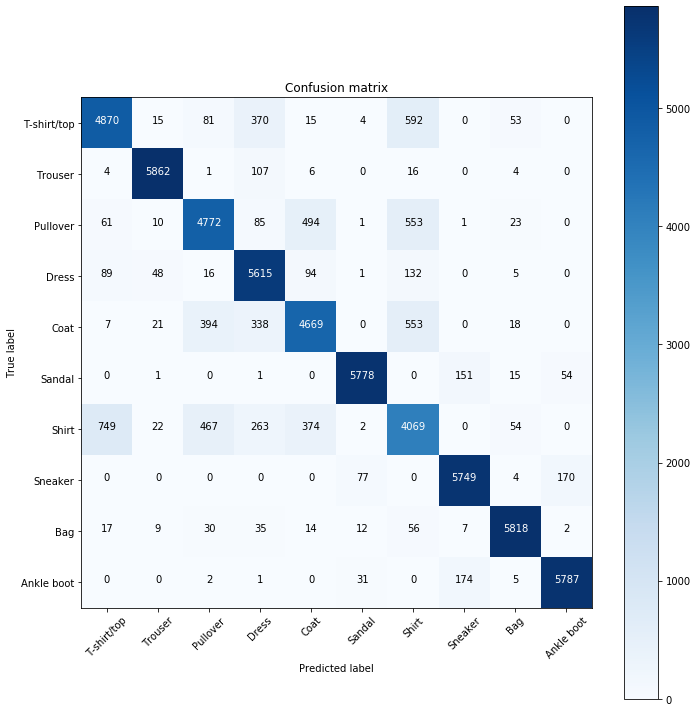

In [46]:
names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)